<a href="https://colab.research.google.com/github/suchitra2020180/Data_Analysis/blob/main/Project12_PotatoDiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [79]:
# Check TensorFlow and Keras versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.4.1


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32 #standard batch size
CHANNELS=3
EPOCHS=50

In [4]:
# Convert the data to tf.data.dataset. This help us to download data in batches.
#Here PlantVillage is our directory. Here the data is arranged in 3 different folders with different names
# Path to the dataset in Google Drive
dataset_dir = "//content/drive/MyDrive/Jobs_Projects_Doc/python_datasets_code/PotatoDiseaseClassification/PlantVillage"  # Adjust this to your actual dataset path
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
#FOUNd 2152 files belonging to 3 classes

Found 2152 files belonging to 3 classes.


In [5]:
#To class names (or folder names inside the dataset)
class_names=dataset.class_names
class_names
#['potato_EarlyBlight,... folders']

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)
#o/p:68.batches
#Every element is a batch of 32 images
#So 68*32=2176 (It should be 2152,  the last batch may have less data)

68

In [6]:
#Lets explore more abt dataset
#1batch is 32 images
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy()) #gives for 32 batches

#o/p:(32,256,256,3)
#Here 3 is rgb channels

(32, 256, 256, 3)
[0 0 0 0 1 1 1 1 1 1 1 0 2 1 0 0 0 0 0 1 2 1 1 1 1 0 0 0 1 0 1 0]


In [ ]:
#Printing the first image
for image_batch, label_batch in dataset.take(1):
  #Here take(1) indicates take the first batch from dataset
  print(image_batch[0].numpy())

#returns image whose pixel values range between 0-255.

[[[144. 145. 163.]
  [151. 152. 170.]
  [163. 164. 182.]
  ...
  [147. 145. 159.]
  [152. 150. 164.]
  [172. 170. 184.]]

 [[172. 173. 191.]
  [163. 164. 182.]
  [157. 158. 176.]
  ...
  [138. 136. 150.]
  [136. 134. 148.]
  [146. 144. 158.]]

 [[163. 164. 182.]
  [152. 153. 171.]
  [151. 152. 170.]
  ...
  [138. 136. 150.]
  [137. 135. 149.]
  [146. 144. 158.]]

 ...

 [[199. 196. 205.]
  [197. 194. 203.]
  [190. 187. 196.]
  ...
  [149. 144. 151.]
  [152. 147. 154.]
  [148. 143. 150.]]

 [[197. 194. 203.]
  [194. 191. 200.]
  [184. 181. 190.]
  ...
  [149. 144. 151.]
  [155. 150. 157.]
  [169. 164. 171.]]

 [[198. 195. 204.]
  [196. 193. 202.]
  [186. 183. 192.]
  ...
  [150. 145. 152.]
  [155. 150. 157.]
  [165. 160. 167.]]]


In [14]:
#takes first image from first batch
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape) #takes first image from first batch

(256, 256, 3)


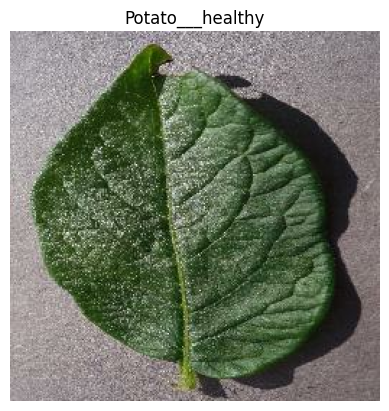

In [15]:
#Lets visualise the image, by convering to numpy array  (and also add datatype. If any errors then change the datatype)
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  #plt.title(label_batch[0]) #This will give only number but we need the class name, so next step
  plt.title(class_names[label_batch[0]])
  plt.axis("off")#we dont want numbers

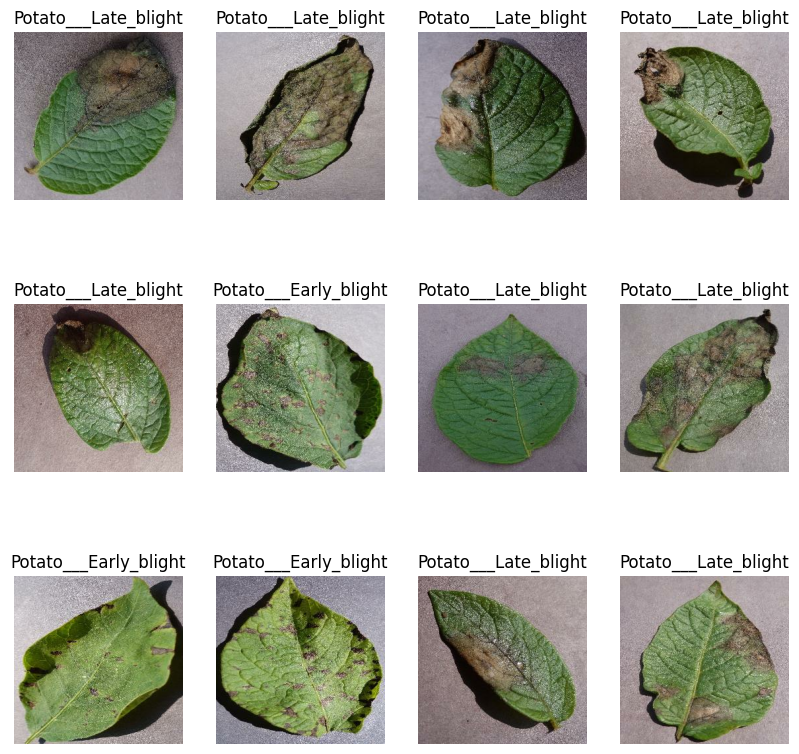

In [16]:
#Lets image 12 images from first batch
fig=plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
#Lets split the dataset into train(80%) , validation(10%)and test(10%) to test the accuracy of the model

In [17]:
train_size=0.8 #80%
data_req_for_training=len(dataset)*train_size
data_req_for_training

54.400000000000006

In [18]:
#Similar to slicing dataset[:54]
train_ds=dataset.take(54) #Takes first 54 images as training dataset
len(train_ds)

54

In [19]:
#Now consider test data and validation data by removing the firdt 54 images
test_ds=dataset.skip(54)
len(test_ds)
#Testing data has 14 images

14

In [20]:
#Our validation set is 10%
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [21]:
#Take 6 samples from the dataset for validation
val_ds=test_ds.take(6)
len(val_ds)

6

In [22]:
#Remaining samples in test dataset is considerd for testing. So skip those 6 samples considered for validation
test_ds=test_ds.skip(6)
len(test_ds)

8

In [24]:
#Converting the process of splitting the dataset into  a train,test, validation into a python function:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(ds_size*train_split)
  val_size=int(ds_size*val_split)
  #Now take samples from dataset using their size
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [25]:
#Convert the dataset using the function
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
print("length of training data:",len(train_ds))
print("length of validation data:",len(val_ds))
print("length of testing data:",len(test_ds))

length of training data: 54
length of validation data: 6
length of testing data: 8


In [ ]:
#Lets do caching,pre-fecthing (pipeline)
#train_ds.cache() #It will take the image from disk and store it memory so that we need the same image in next iteration, it will use it.
#This will improve the performance of the pipeline
#train_ds.cache().shuffle(1000).prefetch()
#prefetch will bring next set of dataset for iterations.This will also improve the performance.
#Also determine how many batches you want to load while training:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#Now our datasets are optimised for training performance. The training will run fast now
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Creating layers fro [reprocessing]

In [28]:
#Preprocessing the images with scale range from 0 -255 to get 0 -1.
#Using keras pipelining method to rescale and resize the image:
#Its important because during testing even if we provide images which are not 256x256, this code will take care of that image size.
resize_and_rescale=tf.keras.Sequential([
    #layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    #layers.experimental.preprocessing.Rescaling(1.0/255)
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [29]:
#Using Data Augmentation to make our model robust. So when we use the rotated image, zoomd, contrasted image also the model will perform better.
#Thats the idea of data augmentation
data_augmentation=tf.keras.Sequential([
    #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #layers.experimental.preprocessing.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [31]:
#Here we will use convolution neural network with Convolution+ReLu and pooling

# Model Architectute
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3 #3 neurons in last stage
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #convolution layer
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    #Pooling layer
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    #Flatten
    layers.Flatten(),
    #Dense layer
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

#32 layers is by trail and error

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
histroy=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 564s 6s/step - accuracy: 0.4708 - loss: 0.9625 - val_accuracy: 0.4219 - val_loss: 0.8602
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.6067 - loss: 0.7497 - val_accuracy: 0.8229 - val_loss: 0.4456
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.7414 - loss: 0.5660 - val_accuracy: 0.7708 - val_loss: 0.5000
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.7574 - loss: 0.4976 - val_accuracy: 0.8073 - val_loss: 0.4412
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.8512 - loss: 0.3587 - val_accuracy: 0.8333 - val_loss: 0.3688
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.8594 - loss: 0.3446 - val_accuracy: 0.9062 - val_loss: 0.2339
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 372s 6s/step - accuracy: 0.8796 - loss: 0.3329 - val_accuracy: 0.9167 - val_loss: 0.2107
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.9140 - loss: 0.2130 - val_accuracy: 0.9583 - v

In [37]:
#Testing the model with testing images
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9947 - loss: 0.0244


In [38]:
scores

[0.03119630552828312, 0.9921875]

In [39]:
#history
histroy

In [40]:
histroy.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [41]:
histroy.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
#To check only acuracy
acc=histroy.history['accuracy'] #Training accuracy
val_acc=histroy.history['val_accuracy']
loss=histroy.history['loss']
val_loss=histroy.history['val_loss']

#Plotting Accuracy and  Loss

Text(0.5, 1.0, 'Training and Validation loss')

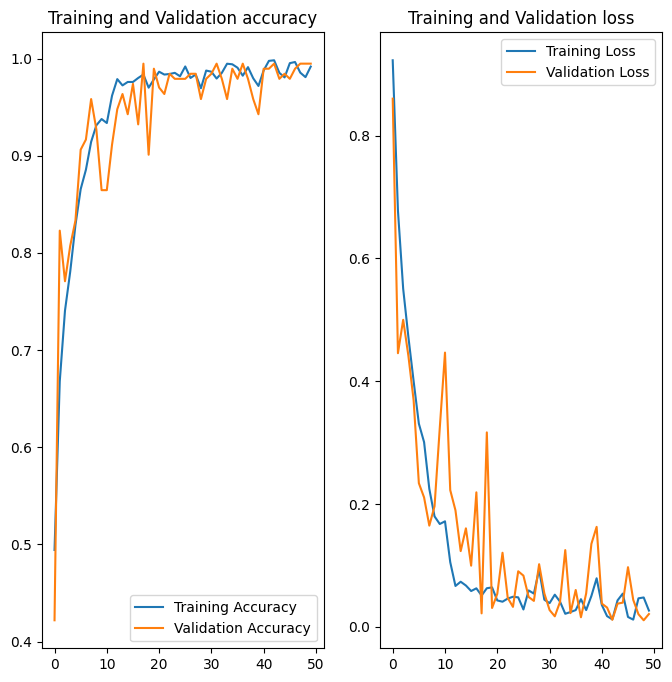

In [49]:
#Plot the accuracies
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

#Prediction

First image to predict
First image's actual label: tf.Tensor(1, shape=(), dtype=int32)
actual class label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[1.8653702e-05 9.9997932e-01 1.9807728e-06]
1
predicted label: Potato___Late_blight


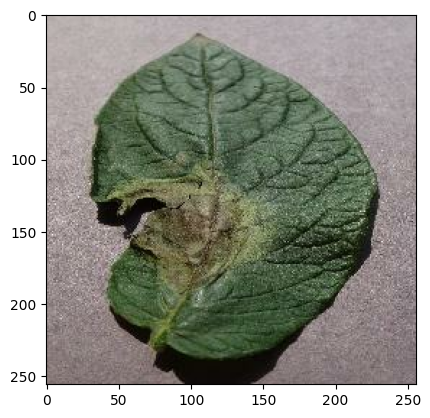

In [50]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0]
  print("First image to predict")
  plt.imshow(first_image)
  print("First image's actual label:", first_label)
  #print("First image's actual label:", first_label.numpy()) #Returns image pixel values
  print("actual class label:",class_names[first_label])

  batch_prediction=model.predict(images_batch) #input is image batch #prediction for 32 images
  #To get prediction of first image:
  print(batch_prediction[0]) #It returns 3 pobabilities beacuse in last layer we n_clsses=3 with softmax function.So, output the class with highest probability
  #To get highest value
  print(np.argmax(batch_prediction[0])) #It gives the location of max number #item at 0 location is maximum
#Converting the number to class name
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:
#Function for predicting the class and confidence
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0) #Creates a batch

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


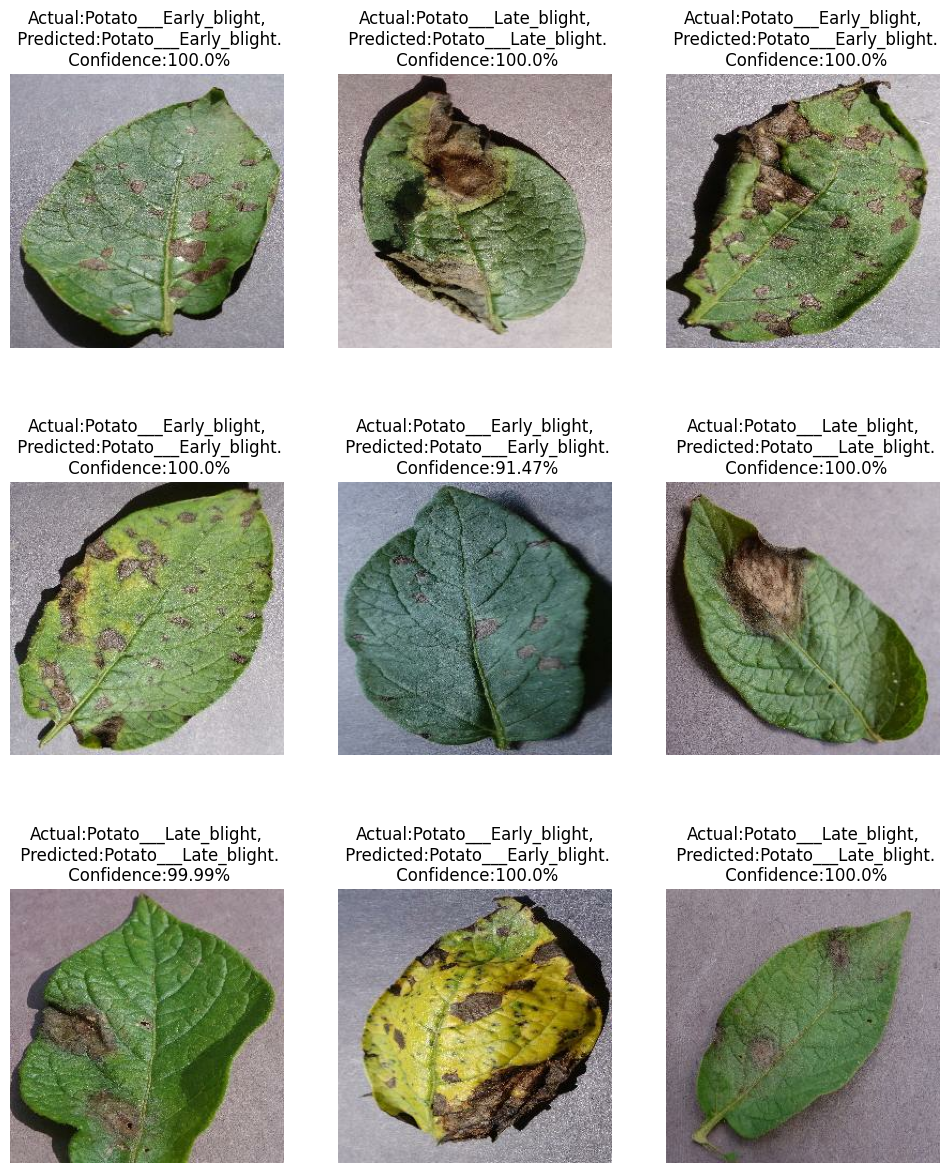

In [55]:
# Do prediction on entire batch and print those:
#Lets do it on only 9 images
plt.figure(figsize=(12,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    #Add title as actual and predicted
    Actual_class=class_names[labels[i]]
    predicted_class, confidence =predict(model,images[i].numpy())
    plt.title(f"Actual:{Actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off")

#Save the model

In [76]:
#Create a new directory to save the models.
import pickle
model_version=1
model.save('/content/drive/MyDrive/Jobs_Projects_Doc/python_datasets_code/PotatoDiseaseClassification/potato_disease_models/potato_leaf_disease_detection_model.h5', save_format='h5')

TypeError: cannot pickle 'module' object

In [65]:
# Save as a TensorFlow SavedModel in .keras format
model.save('/content/drive/MyDrive/Jobs_Projects_Doc/python_datasets_code/PotatoDiseaseClassification/potato_disease_models/potato_leaf_disease_detection_model.keras')

In [74]:
#loading the model (h5 format)
from keras.models import load_model
from keras.models import load_model
model_path='/content/drive/MyDrive/Jobs_Projects_Doc/python_datasets_code/PotatoDiseaseClassification/potato_disease_models/potato_leaf_disease_detection_model.keras'
model_potata_dise=load_model(model_path)

In [75]:
model_potata_dise.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,243 (2.10 MB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 367,496 (1.40 MB)

#Using FastAPI

In [ ]:
#Prerequisites: Fast API, tf.serving (ML ops)